# Comparison of scenarios

post review version, run the `generate_alternative_scenarios.py` script first.
From analysis_opt_newFIG

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetupProvinces
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import os
import tqdm

output_directory = 'model_output/2021-11-23/'
output_prefix = f'altstratint'

# New builder
when = 'future-mobintime'
nnodes = 107
ndays = 90
setup_shared = ItalySetupProvinces(nnodes, ndays, when)
scenarios = {pick_scenario(setup_shared, i)['name']: pick_scenario(setup_shared, i) for i in np.arange(2,13+1)}
summary = pd.DataFrame()
for scn_name, scn in scenarios.items():
    summary = pd.concat([summary, pd.read_csv(f'{output_directory}/{output_prefix}-{scn_name}-ALL.csv')])
    

#summary = pd.read_csv(f'{output_directory}/{output_prefix}-ALL.csv')
summary.replace('U', 'Pessimistic', inplace=True)
summary.replace('L', 'Optimistic', inplace=True)
summary.replace('Population per hab. (focused)', 'Equal (focused)', inplace=True)
summary.replace('Population per hab. (proportional)', 'Equal (proportional)', inplace=True)
summary

Loaded Italy Provincial Setup with 107 nodes.


,method_short,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,newdoseperweek
0,Gre,Greedy,7.278278e+06,1,1.607143e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000
1,sus_pp_f,Susceptible per hab. (focused),7.607884e+06,1,1.607143e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000
2,sus_f,Susceptible (focused),7.692036e+06,1,1.607143e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000
3,sus_pp_p,Susceptible per hab. (proportional),7.324319e+06,1,1.625000e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000
4,sus_p,Susceptible (proportional),7.343807e+06,1,1.625000e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000
...,...,...,...,...,...,...,...,...,...,...
1525,inc_f,Incidence (focused),7.054439e+05,102,2.571429e+07,Optimistic,r15,t2000000,L-r15-t2000000-id13,2000000
1526,inc_pp_p,Incidence per hab. (proportional),6.790036e+05,102,2.609964e+07,Optimistic,r15,t2000000,L-r15-t2000000-id13,2000000
1527,inc_p,Incidence (proportional),6.828772e+05,102,2.609556e+07,Optimistic,r15,t2000000,L-r15-t2000000-id13,2000000
1528,opt,Optimal,6.532479e+05,102,2.603059e+07,Optimistic,r15,t2000000,L-r15-t2000000-id13,2000000


In [2]:
summary['averted'] = 0
for ps in tqdm.tqdm(summary['post_sample'].unique()):
    for bs in summary['scenario-beta'].unique():
        n_infected_baseline = summary[(summary['method_short'] == 'nov')&(summary['post_sample']==ps)&(summary['scenario-beta']==bs)]['infected'].iloc[0]
        summary.loc[(summary['post_sample']==ps)&(summary['scenario-beta']==bs), 'averted'] = float(n_infected_baseline) - summary[(summary['post_sample']==ps)&(summary['scenario-beta']==bs)]['infected']
        #print(n_infected_baseline - summary[(summary['post_sample']==ps)&(summary['scenario-beta']==bs)]['infected'])
summary['avertedpervacc'] = summary['averted']/summary['doses']

# 
summary['averted-wrt2opt'] = 0
summary_opt = summary[summary['method']=='Optimal']
for ps in tqdm.tqdm(summary['post_sample'].unique()):
        for sn in summary['scenario'].unique():
            averted_by_opt = summary[(summary['method_short'] == 'opt')&(summary['post_sample']==ps)&(summary['scenario']==sn)]['averted']
            summary.loc[(summary['post_sample']==ps)&(summary['scenario']==sn), 'averted-wrt2opt'] = \
                    summary.loc[(summary['post_sample']==ps)&(summary['scenario']==sn), 'averted']/float(averted_by_opt)*100
            
summary['averted-wrt2opt102'] = 0
summary_opt = summary[(summary['method']=='Optimal')&(summary['post_sample']==102)]
for sn in tqdm.tqdm(summary['scenario'].unique()):
    averted_by_opt_102 = summary[(summary['method_short'] == 'opt')&(summary['post_sample']==102)&(summary['scenario']==sn)]['averted']
    summary.loc[(summary['scenario']==sn), 'averted-wrt2opt102'] = \
                    summary.loc[(summary['scenario']==sn), 'averted']/float(averted_by_opt_102)*100
summary

100%|██████████| 12/12 [00:00<00:00, 159.92it/s]


,method_short,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,newdoseperweek,averted,avertedpervacc,averted-wrt2opt,averted-wrt2opt102
0,Gre,Greedy,7.278278e+06,1,1.607143e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000,632352.572725,0.393464,74.870062,94.126279
1,sus_pp_f,Susceptible per hab. (focused),7.607884e+06,1,1.607143e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000,302745.820769,0.188375,35.844874,45.064002
2,sus_f,Susceptible (focused),7.692036e+06,1,1.607143e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000,218593.869880,0.136014,25.881347,32.537905
3,sus_pp_p,Susceptible per hab. (proportional),7.324319e+06,1,1.625000e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000,586311.374377,0.360807,69.418819,87.273004
4,sus_p,Susceptible (proportional),7.343807e+06,1,1.625000e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000,566823.382015,0.348814,67.111456,84.372197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,inc_f,Incidence (focused),7.054439e+05,102,2.571429e+07,Optimistic,r15,t2000000,L-r15-t2000000-id13,2000000,579505.000629,0.022536,91.737232,91.737232
1526,inc_pp_p,Incidence per hab. (proportional),6.790036e+05,102,2.609964e+07,Optimistic,r15,t2000000,L-r15-t2000000-id13,2000000,605945.322302,0.023217,95.922807,95.922807
1527,inc_p,Incidence (proportional),6.828772e+05,102,2.609556e+07,Optimistic,r15,t2000000,L-r15-t2000000-id13,2000000,602071.723206,0.023072,95.309606,95.309606
1528,opt,Optimal,6.532479e+05,102,2.603059e+07,Optimistic,r15,t2000000,L-r15-t2000000-id13,2000000,631700.987612,0.024268,100.000000,100.000000


In [3]:
#smry[(smry['scenario-tot'] == 't250000')&(smry['post_sample'] == 1)]

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/pandas/core/frame.py:4385: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


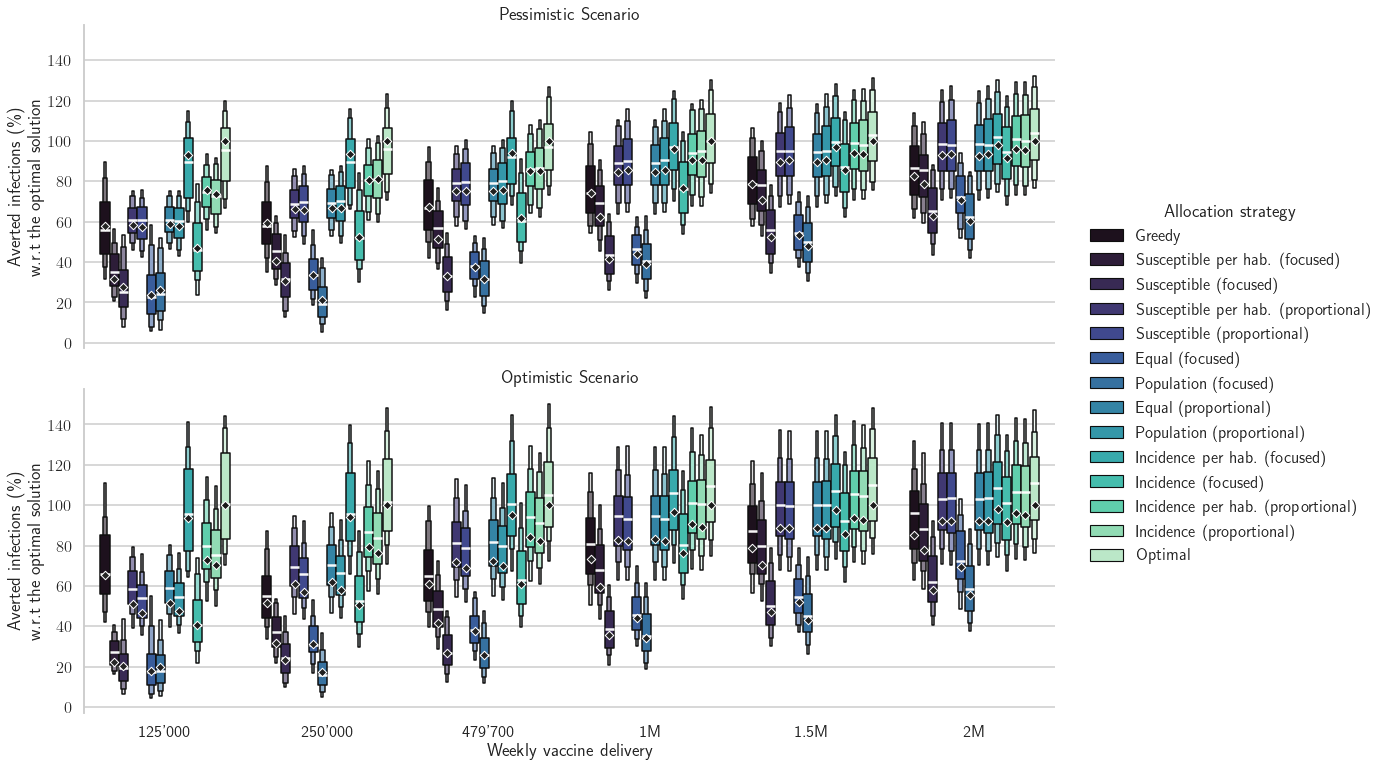

In [43]:
methods = ['sus_pp_f', 'sus_f', 'sus_pp_p', 'sus_p', 'pop_pp_f', 'pop_f',
       'pop_pp_p', 'pop_p', 'inc_pp_f', 'inc_f', 'inc_pp_p', 'inc_p', 'Gre',
       'opt'] #summary['method_short'].unique() - 'nov'
#methods = ['opi', 'finc','fincpp', 'pincpp']
#methods = ['opi', 'pinc','ppop', 'psus']

toplot = "averted-wrt2opt102"
#var_x = "scenario-rate"  
var_x = "newdoseperweek" 

dpw = summary['newdoseperweek'].unique()
dpw = [125000,250000,479700, 1000000,1500000, 2000000]
#dpw = [ 479700, 1000000, 1500000, 2000000]

#smry = summary[(summary['scenario-tot']=='t479700') & (summary['method'].isin(methods))]

smry = summary[(summary['scenario-rate']=='r15') & (summary['method_short'].isin(methods)) & (summary['newdoseperweek'].isin(dpw))]#.sort_values(by=['newdoseperweek','averted'], ascending=[True,False])#.sort_values('method_short')
smry.newdoseperweek = smry.newdoseperweek.astype(str)
smry.replace('125000', "125'000", inplace=True)
smry.replace('479700', "479'700", inplace=True)
smry.replace('250000', "250'000", inplace=True)
smry.replace('1000000', "1M", inplace=True)
smry.replace('1500000', "1.5M", inplace=True)
smry.replace('2000000', "2M", inplace=True)

sns.set_theme(style="whitegrid")
sns.set_context("talk")
mpl.rc('text', usetex=True)
#mpl.rc('font', size=25)
#mpl.rc('legend', fontsize=24)

grid = sns.FacetGrid(smry, 
                     col="scenario-beta",  
                     palette="mako", 
                     height=5.5, 
                     aspect = 2, col_wrap=1, sharey=True,sharex=True, legend_out=True)
def quantile_plot(index, reduction, method, scn_beta, **kwargs):

    g = sns.boxenplot(
            #data=smry,,
            x=index, y=reduction,
            hue=method,
            palette="mako",
            dodge=9,
            #size=2,
            #alpha = .4,
            #inner="stick"
            showfliers=False,
        saturation=1,
        #linewidth=0
        #width=.
        
        )
    ax = plt.gca()
    #ax.set_ylim(0)
    plt.setp(ax.lines, zorder=100)
    plt.legend(loc = 'upper left')
    plt.setp(ax.collections, zorder=100, label="")
    
    
    for line in ax.get_lines():
        line.set_color('white')
        line.set_linewidth(2.5)
        line.set_alpha(10)


# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, var_x, toplot, "method", "scenario-beta")#, marker="o")
g = grid

#grid.add_legend(title='Allocation strategy', loc='center right',bbox_to_anchor=(1,0.57),frameon=True, framealpha=1)

#for ax in g.axes.flat:
#    box = ax.get_position()
#    ax.set_position([box.x0,box.y0,box.width*0.85,box.height])

leg = grid.add_legend(title='Allocation strategy', loc='center left',bbox_to_anchor=(1,0.5))


def quantile_plot(index, reduction, method, scn_beta, **kwargs):
    g2 = sns.stripplot(
        x=var_x,
        y=toplot,
        data = smry[(smry['post_sample']==102) & (smry['scenario-beta']==scn_beta.unique()[0])], 
        dodge=.63, 
        hue="method",
        jitter=False,
        #ax = ax,
        color = 'k',
        #palette="husl",
        marker="D",   # passed to https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter
        s=6, 
        linewidth = 1,
        edgecolor = 'white',
        zorder=100000,
    )
grid.map(quantile_plot, "newdoseperweek", toplot, "method", "scenario-beta")#, marker="o")


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        
# Adjust the arrangement of the plots
#grid.fig.suptitle(run_name)
grid.despine(left=True)
grid.despine(bottom=True)

#grid.set_axis_labels("Stockpile delivery per week","Averted infections after 90 days",)
grid.set_axis_labels("Weekly vaccine delivery","Averted infections (\%) \n w.r.t the optimal solution",)
grid.set_titles(col_template="{col_name} Scenario", row_template="{row_name}", fontsize=40, fontweight='bold')
grid.fig.tight_layout(w_pad=1)
grid.fig.savefig(f'figures/SI_scenarios_perturb_all.pdf', bbox_inches='tight')

In [30]:
a = smry[(smry['post_sample']==102)].pivot_table(columns= ['scenario-beta'], index = ['newdoseperweek', 'method'], values = ['averted', 'avertedpervacc']).sort_values(by=['newdoseperweek',('averted', 'Optimistic')], ascending=False)
a['averted'] = a['averted']/1e6
print(a.to_latex(float_format="{:0.3g}".format).replace('e+06','M').replace('averted}', 'averted (Millions)}'))

\begin{tabular}{llrrrr}
\toprule
     & {} & \multicolumn{2}{l}{averted (Millions)} & \multicolumn{2}{l}{avertedpervacc} \\
     & scenario-beta & Optimistic & Pessimistic &     Optimistic & Pessimistic \\
newdoseperweek & method &            &             &                &             \\
\midrule
479'700 & Optimal &      0.334 &         1.7 &         0.0535 &       0.272 \\
     & Incidence per hab. (focused) &      0.318 &         1.6 &         0.0515 &       0.259 \\
     & Incidence per hab. (proportional) &      0.282 &        1.45 &         0.0452 &       0.232 \\
     & Incidence (proportional) &      0.274 &        1.44 &          0.044 &       0.231 \\
     & Equal (proportional) &      0.241 &        1.28 &         0.0387 &       0.205 \\
     & Susceptible per hab. (proportional) &       0.24 &        1.28 &         0.0384 &       0.205 \\
     & Population (proportional) &      0.232 &        1.29 &         0.0373 &       0.206 \\
     & Susceptible (proportional) &      0

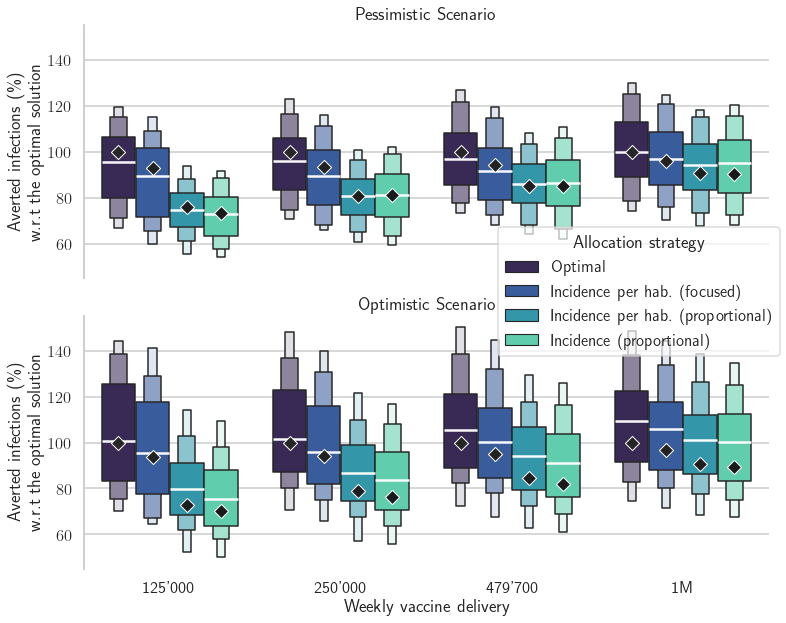

In [42]:
methods = ['inc_pp_f', 'opt', 'inc_p', 'inc_pp_p'] 
dpw = [125000,250000,479700, 1000000]
smry = summary[(summary['scenario-rate']=='r15') & (summary['method_short'].isin(methods)) & (summary['newdoseperweek'].isin(dpw))].sort_values(by=['newdoseperweek','averted'], ascending=[True,False])
smry.newdoseperweek = smry.newdoseperweek.astype(str)
smry.replace('125000', "125'000", inplace=True)
smry.replace('479700', "479'700", inplace=True)
smry.replace('250000', "250'000", inplace=True)
smry.replace('1000000', "1M", inplace=True)
smry.replace('1500000', "1.5M", inplace=True)
smry.replace('2000000', "2M", inplace=True)

sns.set_theme(style="whitegrid")
sns.set_context("talk")
mpl.rc('text', usetex=True)
#mpl.rc('font', size=25)
#mpl.rc('legend', fontsize=24)

grid = sns.FacetGrid(smry, 
                     col="scenario-beta",  
                     palette="mako", 
                     height=4.5, 
                     aspect = 1.6, col_wrap=1, sharey=True,sharex=True, legend_out=True)
def quantile_plot(index, reduction, method, scn_beta, **kwargs):
    g = sns.boxenplot(
            #data=smry,,
            x=index, y=reduction,
            hue=method,
            palette="mako",
            dodge=9,
            #size=2,
            #alpha = .4,
            #inner="stick"
            showfliers=False,
        saturation=1,
        #linewidth=0
        #width=.
    )
    ax = plt.gca()
    #ax.set_ylim(0)
    plt.setp(ax.lines, zorder=100)
    plt.legend(loc = 'upper left')
    plt.setp(ax.collections, zorder=100, label="")
    
    for line in ax.get_lines():
        line.set_color('white')
        line.set_linewidth(2.5)
        line.set_alpha(10)


# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, var_x, toplot, "method", "scenario-beta")#, marker="o")
g = grid

grid.add_legend(title='Allocation strategy', loc='center right',bbox_to_anchor=(1,0.53),frameon=True, framealpha=.7)

for ax in g.axes.flat:
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.85,box.height])

def quantile_plot(index, reduction, method, scn_beta, **kwargs):
    g2 = sns.stripplot(
        x=var_x,
        y=toplot,
        data = smry[(smry['post_sample']==102) & (smry['scenario-beta']==scn_beta.unique()[0])], 
        dodge=.63, 
        hue="method",
        jitter=False,
        #ax = ax,
        color = 'k',
        #palette="husl",
        marker="D",   # passed to https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter
        s=10, 
        linewidth = 1,
        edgecolor = 'white',
        zorder=100000,
    )
grid.map(quantile_plot, "newdoseperweek", toplot, "method", "scenario-beta")#, marker="o")


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        
# Adjust the arrangement of the plots
#grid.fig.suptitle(run_name)
grid.despine(left=True)
grid.despine(bottom=True)

#grid.set_axis_labels("Stockpile delivery per week","Averted infections after 90 days",)
grid.set_axis_labels("Weekly vaccine delivery","Averted infections (\%) \n w.r.t the optimal solution",)
grid.set_titles(col_template="{col_name} Scenario", row_template="{row_name}", fontsize=40, fontweight='bold')
grid.fig.tight_layout(w_pad=1)
grid.fig.savefig(f'figures/scenarios_perturb_all.pdf')

In [28]:
a = smry[(smry['post_sample']==102)].pivot_table(columns= ['scenario-beta'], index = ['newdoseperweek', 'method'], values = ['averted', 'avertedpervacc']).sort_values(by=['newdoseperweek',('averted', 'Optimistic')], ascending=False)
a['averted'] = a['averted']/1e6
print(a.to_latex(float_format="{:0.2g}".format).replace('e+06','M').replace('averted}', 'averted (Millions)}'))

\begin{tabular}{llrrrr}
\toprule
        & {} & \multicolumn{2}{l}{averted (Millions)} & \multicolumn{2}{l}{avertedpervacc} \\
        & scenario-beta & Optimistic & Pessimistic &     Optimistic & Pessimistic \\
newdoseperweek & method &            &             &                &             \\
\midrule
479'700 & Optimal &       0.33 &         1.7 &          0.054 &        0.27 \\
        & Incidence per hab. (focused) &       0.32 &         1.6 &          0.051 &        0.26 \\
        & Susceptible per hab. (focused) &       0.14 &        0.87 &          0.022 &        0.14 \\
        & Population (focused) &      0.086 &        0.54 &          0.014 &       0.087 \\
250'000 & Optimal &       0.23 &         1.1 &           0.07 &        0.34 \\
        & Incidence per hab. (focused) &       0.21 &           1 &          0.067 &        0.32 \\
        & Susceptible per hab. (focused) &      0.072 &        0.45 &          0.022 &        0.14 \\
        & Population (focused) &      0.

# Part 2. Analysis of an optimal solution
From analysis_ts

In [25]:
smry[(smry['post_sample']==102)].pivot_table(columns= ['scenario-beta'], index = ['newdoseperweek', 'method'], values = ['averted', 'avertedpervacc']).sort_values(by=['newdoseperweek',('averted', 'Optimistic')], ascending=False)

averted                \
scenario-beta                                     Optimistic   Pessimistic   
newdoseperweek method                                                        
479'700        Optimal                         333722.710179  1.699157e+06   
               Incidence per hab. (focused)    317508.132679  1.598063e+06   
               Susceptible per hab. (focused)  138487.091608  8.688871e+05   
               Population (focused)             86307.852985  5.361158e+05   
250'000        Optimal                         227762.531570  1.104915e+06   
               Incidence per hab. (focused)    214191.242423  1.032344e+06   
               Susceptible per hab. (focused)   71906.166114  4.486094e+05   
               Population (focused)             39339.463539  2.323280e+05   
1M             Optimal                         483626.202236  2.543881e+06   
               Incidence per hab. (focused)    467216.947467  2.438167e+06   
               Susceptible per hab. (focused)  287039.569983  1.587724e+06   
               Population (focused)            166031.914879  9.961355e+05   
125'000        Optimal                         145833.915899  6.718130e+05   
               Incidence per hab. (focused)    136654.380037  6.255788e+05   
               Susceptible per hab. (focused)   32819.977242  2.132021e+05   
               Population (focused)             28770.437434  1.758965e+05   

                                              avertedpervacc              
scenario-beta                                     Optimistic Pessimistic  
newdoseperweek method                                                     
479'700        Optimal                              0.053515    0.272471  
               Incidence per hab. (focused)         0.051480    0.259107  
               Susceptible per hab. (focused)       0.022454    0.140880  
               Population (focused)                 0.013994    0.086925  
250'000        Optimal                              0.070081    0.339974  
               Incidence per hab. (focused)         0.066637    0.321174  
               Susceptible per hab. (focused)       0.022371    0.139567  
               Population (focused)                 0.012239    0.072280  
1M             Optimal                              0.037202    0.195683  
               Incidence per hab. (focused)         0.036339    0.189635  
               Susceptible per hab. (focused)       0.022325    0.123490  
               Population (focused)                 0.012914    0.077477  
125'000        Optimal                              0.089744    0.413423  
               Incidence per hab. (focused)         0.085029    0.389249  
               Susceptible per hab. (focused)       0.020421    0.132659  
               Population (focused)                 0.017902    0.109447